In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding, LSTM, Dense
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D

from keras.datasets import imdb

Using TensorFlow backend.


In [2]:
import numpy as np
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# call load_data with allow_pickle implicitly set to true
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=20000)

# restore np.load for future normal usage
np.load = np_load_old

17465344/17464789 [==============================] - 0s 0us/step


In [0]:
x_val = x_train[20000:]
y_val = y_train[20000:]
x_train = x_train[:20000]
y_train = y_train[:20000]

In [0]:
x_train = sequence.pad_sequences(x_train, maxlen=200)
x_val = sequence.pad_sequences(x_val, maxlen=200)
x_test = sequence.pad_sequences(x_test, maxlen=200)

### 모델 구성
컨볼루션 레이어에서 나온 특징벡터들을 맥스풀링(MaxPooling1D)를 통해 1/4로 줄여준 다음 LSTM의 입력으로 넣어주는 모델이다.

이때 맥스풀링은 특징벡터 크기를 줄여주는 것이 아니라 특징벡터 수를 줄여준다.

즉 200개 단어가 컨볼루션 레이어를 통과하면 256 크기를 갖는 특징벡터가 198개가 생성되고, 맥스풀링은 특징벡터 198개 중 49개를 골라준다.

따라서 LSTM 레이어의 timesteps는 49개가 됩니다.

(input_dim은 그대로 256이다.)

In [5]:
model = Sequential()
model.add(Embedding(20000, 128))
model.add(Conv1D(256, # filters
                 3, # kernel_size
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

W0805 07:22:40.578003 139770667849600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 07:22:40.612746 139770667849600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 07:22:40.620604 139770667849600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0805 07:22:40.660652 139770667849600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



### 순환 신경망 모델과 순환 컨볼루션 신경망 모델 구성에서 LSTM의 입력 비교

- 순환 신경망 모델(RNN) : LSTM에 입력되는 타임스텝은 Embedding 출력 타임스텝으로 200이고, 특징 크기는 Embedding에서 인코딩된 128이다.


- 순환 컨볼루션 신경망 모델(CNN + RNN) : LSTM에 입력되는 타임스텝은 49, 속성은 256이다. 타임스텝이 49인 이유는 Conv1D에서 200단어를 받아 198개를 반환하고, 이를 다시 MaxPooling1D에 의해 1/4배로 줄어들어 49가 된 것이다. 속성이 256인 이유는 Conv1D가 Embedding 출력인 128 벡터를 입력받아 256으로 반환되기 때문이다.

In [6]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 256)         98560     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 256)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               197120    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 2,855,809
Trainable params: 2,855,809
Non-trainable params: 0
_________________________________________________________________
None


### 모델 학습과정 설정

In [7]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

W0805 07:22:40.915149 139770667849600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0805 07:22:40.941833 139770667849600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3376: The name tf.log is deprecated. Please use tf.math.log instead.

W0805 07:22:40.947675 139770667849600 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### 모델 학습시키기

In [8]:
hist = model.fit(x_train,
                 y_train,
                 epochs=25,
                 batch_size=64,
                 validation_data=(x_val, y_val))

W0805 07:22:41.808851 139770667849600 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 20000 samples, validate on 5000 samples
Epoch 1/25
20000/20000 [==============================] - 28s 1ms/step - loss: 0.3910 - acc: 0.8111 - val_loss: 0.3009 - val_acc: 0.8820
Epoch 2/25
20000/20000 [==============================] - 22s 1ms/step - loss: 0.1775 - acc: 0.9361 - val_loss: 0.3132 - val_acc: 0.8710
Epoch 3/25
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0872 - acc: 0.9707 - val_loss: 0.4496 - val_acc: 0.8682
Epoch 4/25
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0338 - acc: 0.9899 - val_loss: 0.5470 - val_acc: 0.8642
Epoch 5/25
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0238 - acc: 0.9929 - val_loss: 0.7451 - val_acc: 0.8524
Epoch 6/25
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0194 - acc: 0.9940 - val_loss: 0.6278 - val_acc: 0.8566
Epoch 7/25
20000/20000 [==============================] - 21s 1ms/step - loss: 0.0229 - acc: 0.9925 - val_loss: 0.6552 - val_acc:

### 테스트 데이터에 대해서 정확도 평가

In [9]:
scores = model.evaluate(x_train, y_train, verbose=0)
print("정확도: %.2f%%" % (scores[1]*100))

정확도: 100.00%


### 학습과정

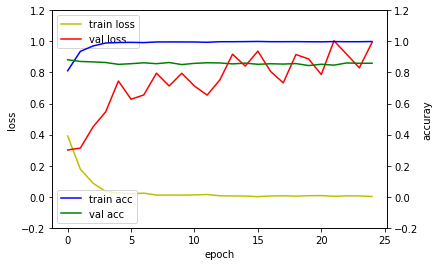

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([-0.2, 1.2])

acc_ax.plot(hist.history['acc'], 'b', label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylim([-0.2, 1.2])

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

### 모델 평가

In [11]:
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=64)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

25000/25000 [==============================] - 5s 212us/step
## evaluation loss and_metrics ##
[1.1294057553482055, 0.8409599999809265]
